## **Loading the Data**

In [45]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine("postgresql+psycopg2://postgres@localhost:5432/retail_forecasting")

# Load cleaned weekly sales
df = pd.read_sql("SELECT * FROM mart.weekly_store_sales ORDER BY week_start, store", engine)
df['week_start'] = pd.to_datetime(df['week_start'])
df.head()


,store,week_start,weekly_sales,weekly_customers,promo_rate
0,1,2012-12-31,19340.0,2500,0.0
1,2,2012-12-31,15407.0,2103,0.0
2,3,2012-12-31,23317.0,2741,0.0
3,4,2012-12-31,36816.0,5423,0.0
4,5,2012-12-31,13764.0,1803,0.0


In [36]:
# Display basic information

print('Dataset Shape:', df.shape)
print('Column Types:', df.dtypes)


Dataset Shape: (145815, 5)
Column Types: store                        int64
week_start          datetime64[ns]
weekly_sales               float64
weekly_customers             int64
promo_rate                 float64
dtype: object


 # EDA

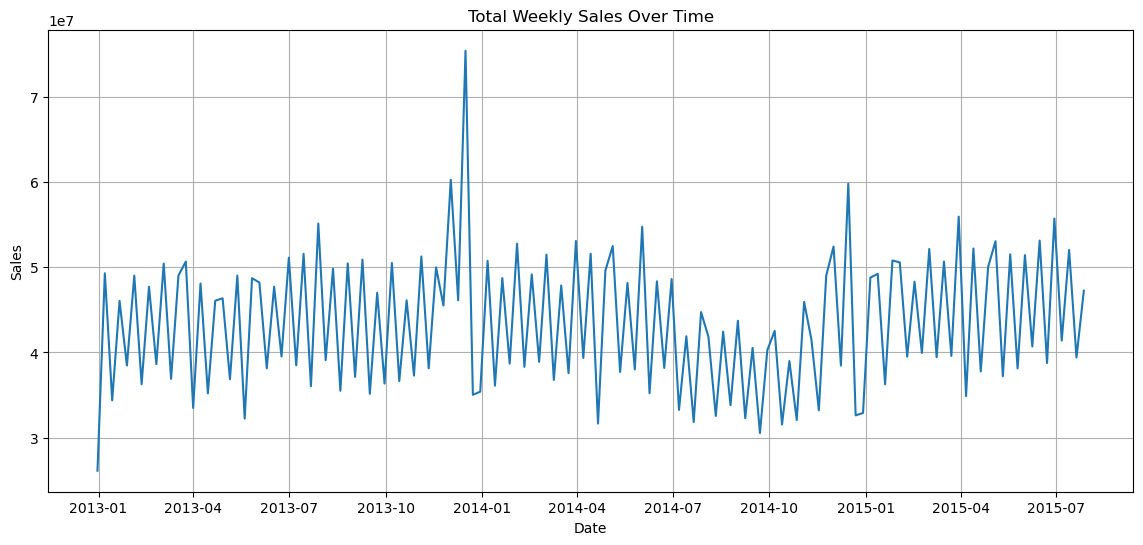

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
total_sales = df.groupby('week_start')['weekly_sales'].sum()
plt.plot(total_sales.index, total_sales.values)

plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

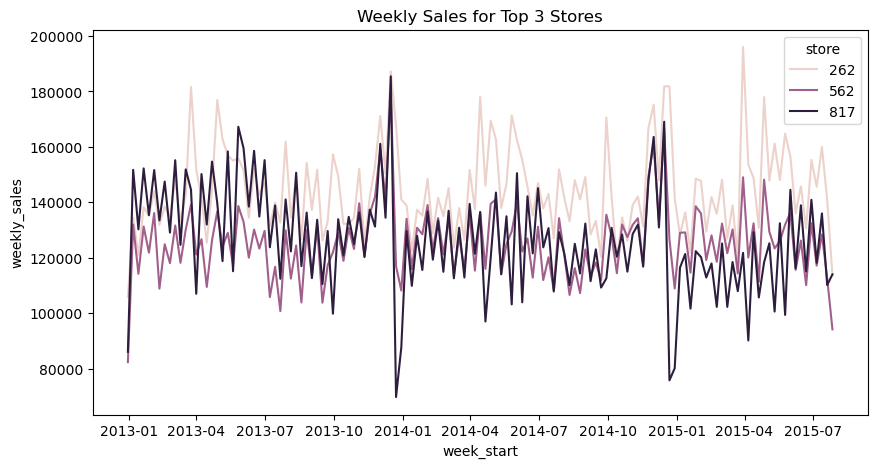

In [38]:
top_stores = df.groupby('store')['weekly_sales'].sum().nlargest(3).index.tolist()
subset = df[df['store'].isin(top_stores)]

plt.figure(figsize=(10,5))
sns.lineplot(data=subset, x='week_start', y='weekly_sales', hue='store')
plt.title('Weekly Sales for Top 3 Stores')
plt.show()

<Axes: title={'center': 'Promo vs No Promo Weekly Sales'}, xlabel='promo_flag'>

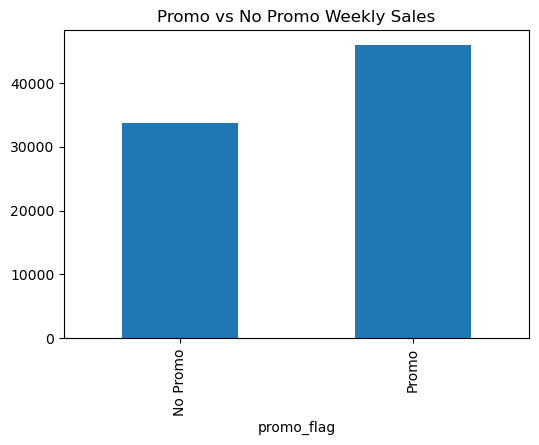

In [39]:
df['promo_flag'] = df['promo_rate'].apply(lambda x: 'Promo' if x > 0 else 'No Promo')
avg_sales = df.groupby('promo_flag')['weekly_sales'].mean()

avg_sales.plot(kind='bar', figsize=(6,4), title='Promo vs No Promo Weekly Sales')

/var/folders/5v/v059m_vd5xd2hzndqfx68g300000gn/T/ipykernel_63077/1609047134.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_avg, x='month', y='weekly_sales', palette='Reds')


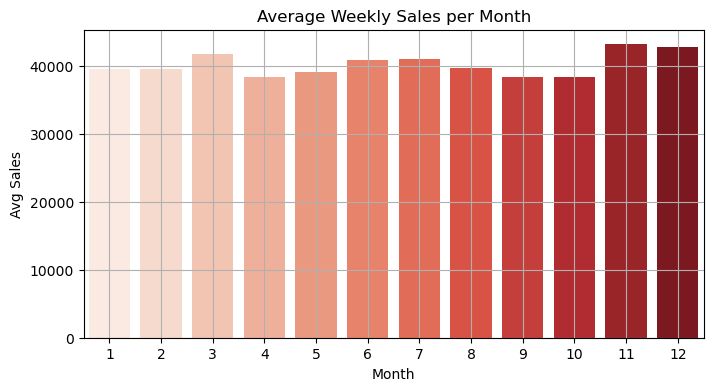

In [40]:
# Add seasonal columns
df['month'] = df['week_start'].dt.month
df['weekofyear'] = df['week_start'].dt.isocalendar().week

# Average sales per month
monthly_avg = df.groupby('month')['weekly_sales'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=monthly_avg, x='month', y='weekly_sales', palette='Reds')
plt.title('Average Weekly Sales per Month')
plt.ylabel('Avg Sales')
plt.xlabel('Month')
plt.grid(True)
plt.show()


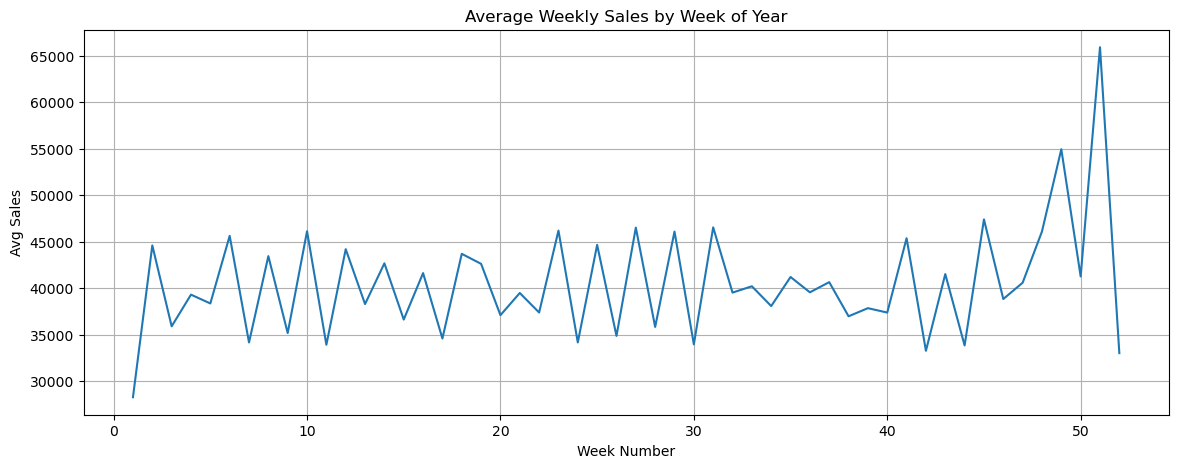

In [41]:
weekly_avg = df.groupby('weekofyear')['weekly_sales'].mean().reset_index()

plt.figure(figsize=(14, 5))
sns.lineplot(data=weekly_avg, x='weekofyear', y='weekly_sales')
plt.title('Average Weekly Sales by Week of Year')
plt.xlabel('Week Number')
plt.ylabel('Avg Sales')
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Avg Weekly Sales: Holidays vs Non-Holidays')

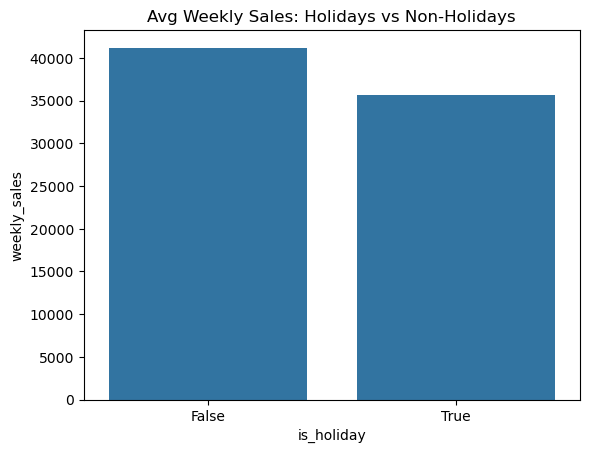

In [42]:
import holidays

de_holidays = holidays.Germany(years=[2013,2014,2015])  # Rossmann is a German chain
df['is_holiday'] = df['week_start'].apply(lambda x: any(day in de_holidays for day in pd.date_range(x, x + pd.Timedelta(days=6))))


holiday_avg = df.groupby('is_holiday')['weekly_sales'].mean().reset_index()

sns.barplot(data=holiday_avg, x='is_holiday', y='weekly_sales')
plt.title('Avg Weekly Sales: Holidays vs Non-Holidays')


                  weekly_sales  weekly_customers
weekly_sales          1.000000          0.828375
weekly_customers      0.828375          1.000000


Text(0.5, 1.02, 'Customers vs Sales')

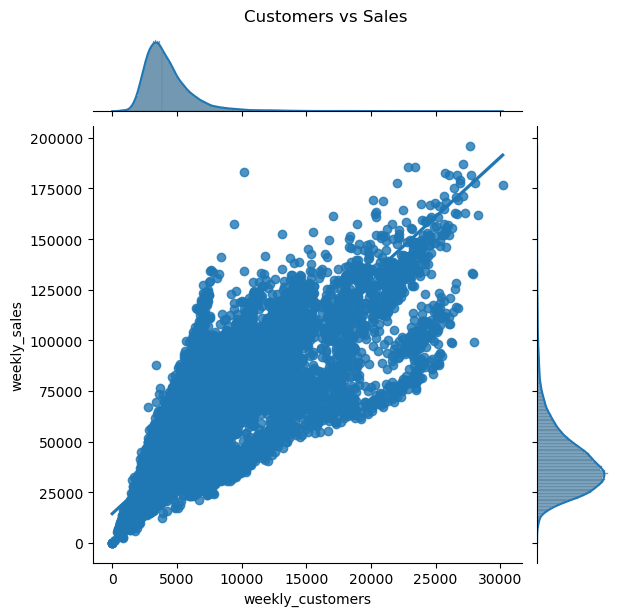

In [43]:
corr = df[['weekly_sales', 'weekly_customers']].corr()
print(corr)

# Visual
sns.jointplot(data=df, x='weekly_customers', y='weekly_sales', kind='reg')
plt.suptitle('Customers vs Sales', y=1.02)


# Feature Engineering

In [48]:
# Adding more time based features 

df['month'] = df['week_start'].dt.month
df['year'] = df['week_start'].dt.year
df['week_of_year'] = df['week_start'].dt.isocalendar().week.astype(int)
df['quarter'] = df['week_start'].dt.quarter
df['is_month_start'] = df['week_start'].dt.is_month_start.astype(int)
df['is_month_end'] = df['week_start'].dt.is_month_end.astype(int)

In [49]:
# Add lag features

def create_lags(data, lags=[1,2,4,12]):
    for lag in lags:
        data[f'lag_{lag}'] = data.groupby('store')['weekly_sales'].shift(lag)
    return data

df = create_lags(df , lags=[1,2,4,12])

In [53]:
# Create rolling mean and std dev features

def create_rolling_features(data, windows=[4,12]):
    for window in windows:
        data[f'rolling_mean_{window}'] = data.groupby('store')['weekly_sales'].shift(1).rolling(window).mean()
        data[f'rolling_std_{window}'] = data.groupby('store')['weekly_sales'].shift(1).rolling(window).std()
    return data

df = create_rolling_features(df)

df.head()

,store,week_start,weekly_sales,weekly_customers,promo_rate,month,year,week_of_year,quarter,is_month_start,is_month_end,lag_1,lag_2,lag_4,lag_12,rolling_mean_4,rolling_std_4,rolling_mean_12,rolling_std_12
0,1,2012-12-31,19340.0,2500,0.0,12,2012,1,4,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2012-12-31,15407.0,2103,0.0,12,2012,1,4,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2012-12-31,23317.0,2741,0.0,12,2012,1,4,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2012-12-31,36816.0,5423,0.0,12,2012,1,4,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2012-12-31,13764.0,1803,0.0,12,2012,1,4,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
#Promotion Features

df['promo_flag'] = (df['promo_rate'] > 0).astype(int)

# Lagged promo effects (did a promo last week impact this week?)
df['promo_lag_1'] = df.groupby('store')['promo_flag'].shift(1)

In [55]:
# Add Store Metadata

store = pd.read_sql('SELECT * FROM raw.store', engine)

df = df.merge(store[['store','storetype', 'assortment', 
                     'competitiondistance', 
                     'competitionopensincemonth',
                     'competitionopensinceyear',
                     'promo2']], on='store', how='left')



In [ ]:
# Check for missing values and drop any

print(df.isnull().sum())

df = df.dropna().reset_index(drop=True)


store                        0
week_start                   0
weekly_sales                 0
weekly_customers             0
promo_rate                   0
month                        0
year                         0
week_of_year                 0
quarter                      0
is_month_start               0
is_month_end                 0
lag_1                        0
lag_2                        0
lag_4                        0
lag_12                       0
rolling_mean_4               0
rolling_std_4                0
rolling_mean_12              0
rolling_std_12               0
promo_flag                   0
promo_lag_1                  0
storetype                    0
assortment                   0
competitiondistance          0
competitionopensincemonth    0
competitionopensinceyear     0
promo2                       0
dtype: int64
store                        0
week_start                   0
weekly_sales                 0
weekly_customers             0
promo_rate                

In [ ]:
# Save the dataframe as a CSV file
df.to_csv("rossmann_features.csv", index=False)
